### Authors:
Gabriele Bani 11640758

Andrii Skliar 11636785

# Lab 2: Inference in Graphical Models

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two people.
* The deadline is Thursday, 29.04, 23:59.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Introduction
In this assignment, we will implement the sum-product and max-sum algorithms for factor graphs over discrete variables. The relevant theory is covered in chapter 8 of Bishop's PRML book, in particular section 8.4. Read this chapter carefuly before continuing!

We will implement sum-product and max-sum and apply it to a poly-tree structured medical diagnosis example.

For this assignment you should use numpy ndarrays (constructed with np.array, np.zeros, np.ones, etc.). We need n-dimensional arrays in order to store conditional distributions with more than one conditioning variable. If you want to perform matrix multiplication on arrays, use the np.dot function; all infix operators including *, +, -, work element-wise on arrays.

## Part 0: Doing the math (5 points)
We start with a set of three Bernoulli distributed variables X, Y, Z. Calculate the marginals $p(Y=1)$ and $p(Y=0)$ using only the sum and product rule where,

$$
p(X=1) = 0.05 \\\\
p(Z=1) = 0.2 \\\\
$$
$$
p(Y = 1 | X = 1, Z = 1) = 0.99 \\\\
p(Y = 1 | X = 1, Z = 0) = 0.9 \\\\
p(Y = 1 | X = 0, Z = 1) = 0.7 \\\\
p(Y = 1 | X = 0, Z = 0) = 0.0001 \\\\
$$

While implementing the message passing algorithms you should be able to use the results of this question as a guidance.

\begin{align*}
p(Y=1) &= p(Y=1|X=1,Z=1)\cdot p(X=1)\cdot p(Z=1) + p(Y=1|X=1,Z=0)\cdot p(X=1)\cdot p(Z=0)\\
&+ p(Y=1|X=0,Z=1)\cdotp(X=0)\cdotp(Z=1) + p(Y=1|X=0,Z=0)\cdot p(X=0)\cdot p(Z=0) \\
&= p(Y=1|X=1,Z=1)\cdot p(X=1)\cdot p(Z=1) + p(Y=1|X=1,Z=0)\cdot p(X=1)\cdot (1 - p(Z=1))\\
&+ p(Y=1|X=0,Z=1)\cdot (1 - p(X=1)) \cdot p(Z=1) + p(Y=1|X=0,Z=0)\cdot (1 - p(X=1))\cdot (1 - p(Z=1)) \\
&= 0.99 \cdot 0.05 \cdot 0.2 + 0.9 \cdot 0.05 \cdot 0.8 + 0.7 \cdot 0.95 \cdot 0.2 + 0.0001 \cdot 0.95 \cdot 0.8 = 0.178976\\
p(Y=0) &= (1 - p(Y=1)) = (1 - 0.178976) = 0.821024
\end{align*}

In [1]:
# Calculate marginals for all the variables
# this is not required, we added it for double checking
import numpy as np
px = np.array([0.95, 0.05])
pz = np.array([0.80, 0.20])
m = np.array([
    [
        [0.9999, 0.3], 
        [0.1, 0.01]
    ], 
    [
        [0.0001, 0.7], 
        [0.9, 0.99]
    ]
])

joint = np.zeros(m.shape)
for x in range(2):
    for y in range(2):
        for z in range(2):
            joint[x, y, z] = np.around(m[y, x, z] * px[x]*pz[z], 6)
            print(f'joint -> y={y}, x={x}, z={z}, {joint[x, y, z]}')
print('marginal for y')
print(joint.sum(0).sum(1))
print('marginal for x (given)')
print(joint.sum(1).sum(1))
print('marginal for z (given)')
print(joint.sum(0).sum(0))

joint -> y=0, x=0, z=0, 0.759924
joint -> y=0, x=0, z=1, 0.057
joint -> y=1, x=0, z=0, 7.6e-05
joint -> y=1, x=0, z=1, 0.133
joint -> y=0, x=1, z=0, 0.004
joint -> y=0, x=1, z=1, 0.0001
joint -> y=1, x=1, z=0, 0.036
joint -> y=1, x=1, z=1, 0.0099
marginal for y
[0.821024 0.178976]
marginal for x (given)
[0.95 0.05]
marginal for z (given)
[0.8 0.2]


## Part 1: The sum-product algorithm

We will implement a data structure to store a factor graph and to facilitate computations on this graph. Recall that a factor graph consists of two types of nodes, factors and variables. Below you will find some classes for these node types to get you started. Carefully inspect this code and make sure you understand what it does. Step by step will update its functionality.

In [2]:
%pylab inline

class Node(object):
    """
    Base-class for Nodes in a factor graph. Only instantiate sub-classes of Node.
    """
    def __init__(self, name):
        # A name for this Node, for printing purposes
        self.name = name
        
        # Neighbours in the graph, identified with their index in this list.
        # i.e. self.neighbours contains neighbour 0 through len(self.neighbours) - 1.
        self.neighbours = []
        
        # Reset the node-state (not the graph topology)
        self.reset()
        
    def reset(self):
        # Incomming messages; a dictionary mapping neighbours to messages.
        # That is, it maps  Node -> np.ndarray.
        self.in_msgs = {}
        
        # A set of neighbours for which this node has pending messages.
        # We use a python set object so we don't have to worry about duplicates.
        self.pending = set([])

    def add_neighbour(self, nb):
        self.neighbours.append(nb)

    def send_sp_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_sp_msg not implemented in base-class Node')
   
    def send_ms_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_ms_msg not implemented in base-class Node')
    
    def receive_msg(self, other, msg):
        # Store the incomming message, replacing previous messages from the same node
        self.in_msgs[other] = msg

        # TODO: add pending messages
        # self.pending.update(...)
    
    def __str__(self):
        # This is printed when using 'print node_instance'
        return self.name


class Variable(Node):
    def __init__(self, name, num_states):
        """
        Variable node constructor.
        Args:
            name: a name string for this node. Used for printing. 
            num_states: the number of states this variable can take.
            Allowable states run from 0 through (num_states - 1).
            For example, for a binary variable num_states=2,
            and the allowable states are 0, 1.
        """
        self.num_states = num_states
        
        # Call the base-class constructor
        super(Variable, self).__init__(name)
    
    def set_observed(self, observed_state):
        """
        Set this variable to an observed state.
        Args:
            observed_state: an integer value in [0, self.num_states - 1].
        """
        # Observed state is represented as a 1-of-N variable
        # Set all-but-one states to a very low probability;
        # (a bit of a hack to avoid -inf values when taking logs)
        self.observed_state[:] = 1e-10
        self.observed_state[observed_state] = 1.0
        
    def set_latent(self):
        """
        Erase an observed state for this variable and consider it latent again.
        """
        # No state is preferred, so set all entries of observed_state to 1.0
        # Using this representation we need not differentiate observed an latent
        # variables when sending messages.
        self.observed_state[:] = 1.0
        
    def reset(self):
        super(Variable, self).reset()
        self.observed_state = np.ones(self.num_states)
        
    def marginal(self):
        """
        Compute the marginal distribution of this Variable.
        It is assumed that message passing has completed when this function is called.
        """
        # TODO: compute marginal
        return None
    
    def unnormalized_log_marginal(self):
        """
        Compute the unnormalized log marginal distribution of this Variable.
        It is assumed that message passing has completed when this function is called.
        """
        # TODO: compute unnormalized log marginal
        return None
    
    def send_sp_msg(self, other):
        # TODO: implement Variable -> Factor message for sum-product
        pass
   
    def send_ms_msg(self, other):
        # TODO: implement Variable -> Factor message for max-sum
        pass

class Factor(Node):
    def __init__(self, name, f, neighbours):
        """
        Factor node constructor.
        Args:
            name: a name string for this node. Used for printing
            f: a numpy.ndarray with N axes, where N is the number of neighbours.
               That is, the axes of f correspond to variables, and the index along that axes corresponds to a value of that variable.
               Each axis of the array should have as many entries as the corresponding neighbour variable has states.
            neighbours: a list of neighbouring Variables. Bi-directional connections are created.
        """
        # Call the base-class constructor
        super(Factor, self).__init__(name)
        
        f = np.array(f)  # For convenience, accept lists (of lists (of numbers or potentially lists of ...))
        
        assert len(neighbours) == f.ndim, 'Factor function f should accept as many arguments as this Factor node has neighbours'
        
        for nb_ind in range(len(neighbours)):
            nb = neighbours[nb_ind]
            assert f.shape[nb_ind] == nb.num_states, 'The range of the factor function f is invalid for input %i %s' % (nb_ind, nb.name)
            self.add_neighbour(nb)
            nb.add_neighbour(self)

        self.f = f
        
    def send_sp_msg(self, other):
        # TODO: implement Factor -> Variable message for sum-product
        pass
   
    def send_ms_msg(self, other):
        # TODO: implement Factor -> Variable message for max-sum
        pass


Populating the interactive namespace from numpy and matplotlib


### 1.1. Initialize the graph (5 points)
The equations in Part 0 can be represented by a factor graph. Instantiate this graph by creating Variable and Factor instances and linking them according to the graph structure. 
To instantiate the factor graph, first create the Variable nodes and then create Factor nodes, passing a list of neighbour Variables to each Factor. To get you started, we initialize the variable node for $X$ and the factor node corresponding to the prior $p(X)$.

In [3]:
X = Variable(name='X', num_states=2)
X_prior = Factor(name='p(X)',
                 f=np.array([0.95, 0.05]),
                 neighbours=[X])

# Please stick to the naming convention used below, otherwise the test functionality throughout the lab won't work
Z = Variable(name='Z', num_states=2)
Z_prior = Factor(name='p(Z)',
                 f=np.array([0.80, 0.20]),
                 neighbours=[Z])
                 
Y = Variable(name='Y', num_states=2)
Y_cond = Factor(name='p(Y | X, Z)',
                 f=np.array([
                 [[0.9999, 0.3], [0.1, 0.01]],
                 [[0.0001, 0.7], [0.9, 0.99]],
                 ]),
                 neighbours=[Y, X, Z])  

In [4]:
### Test test test
assert Z_prior.f.shape == (2,)
assert Y_cond.f.shape == (2, 2, 2)



We will be doing a lot of marginalizations, i.e. obtain the distribution of a *single* variable from a distribution over multiple variables. Let's first write a function `marginalize` for that.

In [5]:
# To marginalize, we sum over all variables except for the one, that we are interested in
def marginalize(P, dim):
    n_dims = len(P.shape)
    indexes = tuple(i for i in range(n_dims) if i != dim)
    return np.sum(P, indexes)

# Lets try it
test_P = np.random.rand(2, 3, 4)
test_P = test_P / test_P.sum()  # Normalize for proper distribution

# Do the marginal distributions look like you expect?
print (marginalize(test_P, 0))
print (marginalize(test_P, 1))
print (marginalize(test_P, 2))


[0.57354891 0.42645109]
[0.42323629 0.20899062 0.36777309]
[0.23683897 0.16852547 0.3175838  0.27705176]


### 1.2 Factor to variable messages (20 points)
Write a method `send_sp_msg(self, other)` for the Factor class, that checks if all the information required to pass a message to `Variable` `other` is present, computes the message and sends it to `other`. "Sending" here simply means calling the `receive_msg` function of the receiving node (we will implement this later). The message itself should be represented as a numpy array (np.array) whose length is equal to the number of states of the variable.

In the very end of 1.2 below we overwrite `send_sp_msg(self, other)` for the Factor class. In general, this is considered bad practise but in this lab it saves us from scrolling up and down all the time.

You will implement a function `send_sp_msg` that sends a message from a factor to a variable for the max-sum algorith. This function implements Equation 8.66 from Bishop. The message should be a numpy array (np.array) whose length is equal to the number of states of the variable.

It is a good idea to write a number of helper functions to implement these equations.

Since it is always a good idea to include checks, you should first write a method `can_send_message` that checks whether a node `node` has all the information required to pass a message to `other`. This should work for both variable and factor nodes.

In [6]:
# We check if all the messages for a receiver have been received
# If there is at least one message missing - we return False
def can_send_message(sender, receiver):
    for neighbour in sender.neighbours:
        if neighbour == receiver:
            continue
        if neighbour not in sender.in_msgs.keys():
            return False
    
    return True



# Do the results make sense?
print (can_send_message(X, X_prior))
print (can_send_message(X_prior, X))


False
True



In Eq. 8.66, Bishop writes $f(x, x_1, ..., x_M)$, where $x$ corresponds to the variable that will receive the message. For now, assume this variable is the `index`-th neighbour of the factor. In order to ease implementation, it may be a good idea to write a function that rearanges the dimensions of `f` to comply with this notation, i.e. moves the dimension `index` to the front. Make sure to return a copy and keep all other dimensions in order! Use `np.moveaxis`.

In [7]:
def move_dimension_first(f, index):
    moved = np.moveaxis(f, index, 0)
    return moved
    

You should calculate the product of the incoming messages of all neighbours of the sending node except the receiving node. Therefore it may be useful to write a function `get_neighbour_messages` that gathers these messages in a list. If you want to not make things complicated, make sure the order of the messages in the list corresponds to the order of the variables in `neighbours`.

In [8]:
# We get messages from all the neighbours except for the receiver
# We do an additional check to ensure that the message from a specified neighbour is actually in the list of incoming messages
def get_neighbour_messages(sender, receiver):
    l = [sender.in_msgs[n] for n in sender.neighbours if n != receiver and n in sender.in_msgs]
    return l

Before marginalizing, we need to calculate $\prod_{m\in\text{ne}(f_s)\setminus x} \mu_{x_m\rightarrow f_s}(x_m)$ (Eq. 8.66) for all possible combinations of $x_1, ..., x_M$ (values of the neighbour nodes except the receiving node). An elegant and efficient way to calculate these is using the n-way outer product of vectors. This product takes n vectors $\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(n)}$ and computes a $n$-dimensional tensor (ndarray) whose element $i_0,i_1,...,i_n$ is given by $\prod_j \mathbf{x}^{(j)}_{i_j}$. In python, this is realized as `np.multiply.reduce(np.ix_(*vectors))` for a python list `vectors` of 1D numpy arrays. Try to figure out how this statement works -- it contains some useful functional programming techniques. What should `vectors` be? Try to see the link between the result and Eq. 8.66.

In [9]:
def calc_other_neighbour_msg_prod(sender, receiver):
    messages = get_neighbour_messages(sender, receiver)
    prod = np.multiply.reduce(np.ix_(*messages))
    
    return prod

Following Eq. 8.66, before marginalizing, you should calculate the product of $f(x, x_1, ..., x_M)$ with $\prod_{m\in\text{ne}(f_s)\setminus x} \mu_{x_m\rightarrow f_s}(x_m)$ for all configurations of $x, x_1, ..., x_M$. Since the second part does not depend on $x$, its tensor representations are of different dimensions. You can overcome this problem by using a loop, but preferably use numpy broadcasting by first aligning the dimensions of the tensors. You can use `np.expand_dims` or `X[None, ...]` to insert one dimension at the front. Write a function `calculate_factor` that, given `f` (which is reordered such that $x$ corresponds to the first dimension) and the (outer) product of the other neighbour messages, computes $f(x, x_1, ..., x_M) \prod_{m\in\text{ne}(f_s)\setminus x} \mu_{x_m\rightarrow f_s}(x_m)$ for all configurations of $x, x_1, ..., x_M$.

In [10]:
def calculate_factor(f_neighb_first, neighbour_msg_prod):
    # Because of the broadcasting rules of numpy, we don't necessarily need to expand dimensions before multiplication
    factor = f_neighb_first * neighbour_msg_prod
    return factor


Put all the pieces together to define a function `calc_sum_product_factor_to_variable_msg` that calculates Eq. 8.66.

In [11]:
def calc_sum_product_factor_to_variable_msg(factor, variable):
    var_index = factor.neighbours.index(variable)
    f_neighb_first = move_dimension_first(factor.f, var_index)
    neighbour_msg_prod = calc_other_neighbour_msg_prod(factor, variable)

    f2 = calculate_factor(f_neighb_first, neighbour_msg_prod)
    f = marginalize(f2, 0)
    return f


In [12]:
# Finally, we will define the send message function for you
# Note, that we have edited the cell in order to return message 
# It is being printed during backward and forward pass, which greatly simplified the debugging procedure for us
def factor_send_sp_msg(self, variable):
    
    assert isinstance(variable, Variable), "Factor can only send messages to variable!"
    assert can_send_message(self, variable), "Cannot send message!"
    
    out_msg = calc_sum_product_factor_to_variable_msg(self, variable)
    
    # Send the message
    variable.receive_msg(self, out_msg)
    
    # Remove the pending sign if present
    self.pending.discard(variable)
    return out_msg
    
Factor.send_sp_msg = factor_send_sp_msg


In [13]:
### Test test test
# message from X_prior to X
X_prior.reset()
X.reset()

X_prior.send_sp_msg(X)
assert np.allclose(list(X.in_msgs.values()), [0.95, 0.05])

# message from Z_prior to Z
Z_prior.reset()
Z.reset()

Z_prior.send_sp_msg(Z)
assert np.allclose(list(Z.in_msgs.values()), [0.8, 0.2])

# message from Y_cond to Y
Y_cond.reset()
Y.reset()

Y_cond.receive_msg(X, X_prior.f) # simulating that Y_cond received all necessary messages from X
Y_cond.receive_msg(Z, Z_prior.f) # simulating that Y_cond received all necessary messages from Z
Y_cond.send_sp_msg(Y)
assert np.allclose(list(Y.in_msgs.values()), [0.821024, 0.178976])


### 1.3 Variable to factor messages (10 points)

Write a method `calc_sum_product_variable_to_factor_msg(variable, factor)` that computes the message to be sent to a neighbour variable by a factor.

In [14]:
def calc_sum_product_variable_to_factor_msg(variable, factor):
    if len(variable.neighbours) == 1:
        message = np.ones(variable.num_states)
    else:
        messages = get_neighbour_messages(variable, factor)
        # we can do elementwise product because the messages to a variable have the same dimension
        message = np.prod(messages, axis=0)

    return message
    

In [15]:
# Finally, we will define the send message function for you
def variable_send_sp_msg(self, factor):
    
    assert isinstance(factor, Factor), "Variable can only send messages to factor!"
    assert can_send_message(self, factor), "Cannot send message!"
    
    out_msg = calc_sum_product_variable_to_factor_msg(self, factor)
    
    # Send the message
    factor.receive_msg(self, out_msg)
    
    # Remove the pending sign if present
    self.pending.discard(factor)
    return out_msg
    
Variable.send_sp_msg = variable_send_sp_msg


In [16]:
### Test test test
Y_cond.reset()
Y.reset()

# First message from X to Y_cond
X_prior.reset()
X.reset()
X_prior.send_sp_msg(X) # simulating that X received all necessary messages
X.send_sp_msg(Y_cond) 
assert np.allclose(list(Y_cond.in_msgs.values()), [0.95, 0.05])

# Second message from Z to Y_cond
Z_prior.reset()
Z.reset()
Z_prior.send_sp_msg(Z) # simulating that Z received all necessary messages
Z.send_sp_msg(Y_cond)
assert np.allclose(list(Y_cond.in_msgs.values()), [[0.95, 0.05], [0.8, 0.2]])


### Testing a single forward pass and a single backward pass
Before we go on we will make sure that messages can be passed in both directions the graph.

In [17]:
X_prior.reset()
X.reset()
Z_prior.reset()
Z.reset()
Y_cond.reset()
Y.reset()

# Forward pass
X_prior.send_sp_msg(X)
Z_prior.send_sp_msg(Z)
X.send_sp_msg(Y_cond)
Z.send_sp_msg(Y_cond)
Y_cond.send_sp_msg(Y)
assert np.allclose(list(Y.in_msgs.values()), [0.821024, 0.178976])

# Backward pass
Y.send_sp_msg(Y_cond)
Y_cond.send_sp_msg(X)
Y_cond.send_sp_msg(Z)
X.send_sp_msg(X_prior)
Z.send_sp_msg(Z_prior)
assert np.allclose(list(X.in_msgs.values()), [[0.95, 0.05],[1., 1.]])
assert np.allclose(list(Z.in_msgs.values()), [[0.8, 0.2],[1., 1.]])


### 1.4 Compute marginal (10 points)
Later in this assignment, we will implement message passing schemes to do inference. Once the message passing has completed, we will want to compute local marginals for each variable.
Write the method `marginal` for the `Variable` class, that computes a marginal distribution over that node.

In [18]:
def marginal(self):
    marginal = np.multiply.reduce(list(self.in_msgs.values()), 0)
    
    return marginal

Variable.marginal = marginal


In [19]:
### Test test test
# Simulate a single forward pass
X_prior.reset()
X.reset()
Z_prior.reset()
Z.reset()
Y_cond.reset()
Y.reset()

X_prior.send_sp_msg(X)
Z_prior.send_sp_msg(Z)
X.send_sp_msg(Y_cond)
Z.send_sp_msg(Y_cond)
Y_cond.send_sp_msg(Y)

assert np.allclose(X.marginal(), [0.95, 0.05])
assert np.allclose(Z.marginal(), [0.8, 0.2])
assert np.allclose(Y.marginal(), [0.821024, 0.178976])


### 1.5 Receiving messages (10 points)
In order to implement a message passing algorithms, we need some way to determine which nodes are ready to send messages to which neighbours. We make use of the concept of "pending messages", which is explained in Bishop (8.4.7): 
"we will say that a (variable or factor)
node a has a message pending on its link to a node b if node a has received any
message on any of its other links since the last time it sent a message to b. Thus,
when a node receives a message on one of its links, this creates pending messages
on all of its other links."

Before we say node a has a pending message for node b, we **must check that node a has received all messages needed to compute the message that is to be sent to b**.

Modify the function `receive_msg`, so that it updates the self.pending variable as described above. The member self.pending is a set that is to be filled with Nodes to which self has pending messages.

In [20]:
# ANSWER 1.5
def receive_msg(self, other, msg):
    self.in_msgs[other] = msg
    for n in self.neighbours:
        if can_send_message(self, n):
            self.pending.add(n)

Node.receive_msg = receive_msg


In [21]:
### Test test test
X_prior.reset()
X.reset()
assert X_prior.pending == set()

X_prior.pending.add(X)
assert str(list(X_prior.pending)[0]) == X.name

X_prior.send_sp_msg(X)
assert X_prior.pending == set()


### 1.6 Inference Engine (10 points)
Write a function `sum_product(node_list)` that runs the sum-product message passing algorithm on a tree-structured factor graph with given nodes. The input parameter `node_list` is a list of all Node instances in the graph, which is assumed to be ordered correctly. That is, the list starts with a leaf node, which can always send a message. Subsequent nodes in `node_list` should be capable of sending a message when the pending messages of preceding nodes in the list have been sent. The sum-product algorithm then proceeds by passing over the list from beginning to end, sending all pending messages at the nodes it encounters. Then, in reverse order, the algorithm traverses the list again and again sends all pending messages at each node as it is encountered. For this to work, we initialized pending messages for all the leaf nodes, e.g. `X_prior.pending.add(X)`, where `X_prior` is a Factor node corresponding the the prior, `X` is a `Variable` node and the only connection of `X_prior` goes to `X`.

In [22]:
def sum_product(node_list):
    print('Forward pass')
    for i, node in enumerate(node_list):
        # Iterate over all neighbours, which haven't received all necessary messages in the current pass
        # we are using set between neighbours and nodes further in the message passing chain
        # to make sure that we don't send messages back to nodes that have 
        # already "forwarded" messages in a current pass
        for neigh in set(node.neighbours) & set(node_list[i:]):
            if can_send_message(node, neigh):
                msg = node.send_sp_msg(neigh)
                print(f'{node} -> {neigh}: {msg}')
    
    rev_node_list = node_list[::-1]
    print('\nBackward pass')
    for i, node in enumerate(rev_node_list):
        # Again, iterate over all neighbours, which haven't received all necessary messages in the current pass
        for neigh in set(node.neighbours) & set(rev_node_list[i:]):
            if neigh in node.pending:
                msg = node.send_sp_msg(neigh)
                print(f'{node} -> {neigh}: {msg}')


In [23]:
### Test test test
nodes = [X_prior, X, Z_prior, Z, Y_cond, Y]
for n in nodes:
    n.reset()
    
X_prior.pending.add(X)
Z_prior.pending.add(Z)
Y.pending.add(Y_cond)

sum_product(nodes)
assert np.allclose(Y.marginal(), [0.821024, 0.178976])


Forward pass
p(X) -> X: [0.95 0.05]
X -> p(Y | X, Z): [0.95 0.05]
p(Z) -> Z: [0.8 0.2]
Z -> p(Y | X, Z): [0.8 0.2]
p(Y | X, Z) -> Y: [0.821024 0.178976]

Backward pass
Y -> p(Y | X, Z): [1. 1.]
p(Y | X, Z) -> X: [1. 1.]
p(Y | X, Z) -> Z: [1. 1.]
Z -> p(Z): [1. 1.]
X -> p(X): [1. 1.]


### 1.7 Observed variables and probabilistic queries (15 points)
We will now use the inference engine to answer probabilistic queries. That is, we will set certain variables to observed values, and obtain the marginals over latent variables. We have already provided functions `set_observed` and `set_latent` that manage a member of Variable called `observed_state`. Modify the `calc_sum_product_variable_to_factor_msg` and `Variable.marginal` routines that you wrote before, to use `observed_state` so as to get the required marginals when some nodes are observed.

In [24]:
def calc_sum_product_variable_to_factor_msg(variable, factor):
    if len(variable.neighbours) == 1:
        message = np.ones(variable.num_states)
    else:
        messages = get_neighbour_messages(variable, factor)
        message = np.prod(messages, axis=0)

    return message * variable.observed_state


In [25]:
### Test, test, test
X_prior.reset()
X.reset()
Y_cond.reset()

X_prior.send_sp_msg(X)
X.set_observed(0)
X.send_sp_msg(Y_cond)
assert np.allclose(list(Y_cond.in_msgs.values()), [9.5e-01, 5.0e-12])


In [26]:
def marginal(self):
    marginal = np.multiply.reduce(list(self.in_msgs.values()), 0) * self.observed_state
    
    return marginal / marginal.sum()
    

Variable.marginal = marginal


In [27]:
### Test, test, test
# Simulate a single forward pass
X_prior.reset()
X.reset()
Z_prior.reset()
Z.reset()
Y_cond.reset()
Y.reset()

X.set_observed(0)
Z.set_observed(0)

X_prior.send_sp_msg(X)
Z_prior.send_sp_msg(Z)
X.send_sp_msg(Y_cond)
Z.send_sp_msg(Y_cond)
Y_cond.send_sp_msg(Y)

assert np.allclose(Y.marginal(), [9.99900000e-01, 1.00000022e-04])


## Part 2: The max-sum algorithm
Next, we implement the max-sum algorithm as described in section 8.4.5 of Bishop.

### 2.1 Factor to variable messages (10 points)
Implement the function `Factor.send_ms_msg` that sends Factor -> Variable messages for the max-sum algorithm. It is analogous to the `Factor.send_sp_msg` function you implemented before. Make sure it works for observed and unobserved nodes. Consider using a number of helper functions as seen in Part 1.

In [28]:
def ms_calc_other_neighbour_msg_sum(sender, receiver):
    messages = get_neighbour_messages(sender, receiver)
    sum_var = np.add.reduce(np.ix_(*messages))
    return sum_var

In [29]:
def maximize(P, dim):
    n_dims = len(P.shape)
    indexes = tuple(i for i in range(n_dims) if i != dim)
    return np.max(P, indexes) 

In [30]:
def ms_calculate_factor(f_neighb_first, neighbour_msg_prod):
    factor = np.log(f_neighb_first) + neighbour_msg_prod
    return factor

In [31]:
def ms_calc_max_sum_factor_to_variable_msg(factor, variable):
    var_index = factor.neighbours.index(variable)
    f_neighb_first = move_dimension_first(factor.f, var_index)

    neighbour_msg_prod = ms_calc_other_neighbour_msg_sum(factor, variable) + np.log(variable.observed_state)
    f = ms_calculate_factor(f_neighb_first, neighbour_msg_prod)
    return maximize(f, 0) 

In [32]:
def factor_send_ms_msg(self, variable):
    
    assert isinstance(variable, Variable), "Factor can only send messages to variable!"
    assert can_send_message(self, variable), "Cannot send message!"

    out_msg = ms_calc_max_sum_factor_to_variable_msg(self, variable)

    # Send the message
    variable.receive_msg(self, out_msg)

    # Remove the pending sign if present
    self.pending.discard(variable)
    return out_msg
    
Factor.send_ms_msg = factor_send_ms_msg


In [33]:
### Test test test
# message from X_prior to X
X_prior.reset()
X.reset()

X_prior.send_ms_msg(X)
assert np.allclose(list(X.in_msgs.values()), [-0.05129329, -2.99573227])

# message from Z_prior to Z
Z_prior.reset()
Z.reset()

Z_prior.send_ms_msg(Z)
assert np.allclose(list(Z.in_msgs.values()), [-0.22314355, -1.60943791])

# message from Y_cond to Y
Y_cond.reset()
Y.reset()

Y_cond.receive_msg(X, X_prior.f) # simulating that Y_cond received all necessary messages from X
Y_cond.receive_msg(Z, Z_prior.f) # simulating that Y_cond received all necessary messages from Z
Y_cond.send_ms_msg(Y)
assert np.allclose(list(Y.in_msgs.values()), [1.74989999, 0.79332506])


### 2.2 Variable to factor messages (10 points)
Implement the `Variable.send_ms_msg` function that sends Variable -> Factor messages for the max-sum algorithm.

In [34]:
def ms_calc_max_sum_variable_to_factor_msg(variable, factor):
    if len(variable.neighbours) == 1:
        message = np.zeros(variable.num_states) 
    else:
        messages = get_neighbour_messages(variable, factor)
        message = np.sum(messages, axis=0)

    return message + np.log(variable.observed_state)

In [35]:
def variable_send_ms_msg(self, factor):
    out_msg = ms_calc_max_sum_variable_to_factor_msg(self, factor)
    factor.receive_msg(self, out_msg)
    
    # Remove the pending sign if present
    self.pending.discard(factor)
    return out_msg

Variable.send_ms_msg = variable_send_ms_msg


In [36]:
### Test test test
Y_cond.reset()
Y.reset()

# First message from X to Y_cond
X_prior.reset()
X.reset()
X_prior.send_ms_msg(X) # simulating that X received all necessary messages
X.send_ms_msg(Y_cond)
assert np.allclose(list(Y_cond.in_msgs.values()), [-0.05129329, -2.99573227])

# Second message from Z to Y_cond
Z_prior.reset()
Z.reset()
Z_prior.send_ms_msg(Z) # simulating that Z received all necessary messages
Z.send_ms_msg(Y_cond)
assert np.allclose(list(Y_cond.in_msgs.values()), [[-0.05129329, -2.99573227], [-0.22314355, -1.60943791]])


### 2.3 Implement unnormalized log marginal (5 points)
Write the method `unnormalized_log_marginal` for the `Variable` class, that computes a unnormalized log marginal distribution over that node.

In [37]:
def unnormalized_log_marginal(self):
    marginal = np.add.reduce(list(self.in_msgs.values()), 0) + np.log(self.observed_state)
    return marginal

Variable.unnormalized_log_marginal = unnormalized_log_marginal


In [38]:
### Test test test
# Simulate a single forward pass
X_prior.reset()
X.reset()
Z_prior.reset()
Z.reset()
Y_cond.reset()
Y.reset()

X_prior.send_ms_msg(X)
Z_prior.send_ms_msg(Z)
X.send_ms_msg(Y_cond)
Z.send_ms_msg(Y_cond)
Y_cond.send_ms_msg(Y)

assert np.allclose(X.unnormalized_log_marginal(), [-0.05129329, -2.99573227])
assert np.allclose(Z.unnormalized_log_marginal(), [-0.22314355, -1.60943791])
assert np.allclose(Y.unnormalized_log_marginal(), [-0.27453685, -2.01740615])


### 2.4 Find a MAP state (10 points)

Using the same message passing schedule we used for sum-product, implement the max-sum algorithm. For simplicity, we will ignore issues relating to non-unique maxima. So there is no need to implement backtracking; the MAP state is obtained by a per-node maximization (eq. 8.98 in Bishop). Make sure your algorithm works with both latent and observed variables.

In [39]:
def max_sum(node_list):
    print('Forward pass')
    for i, node in enumerate(node_list):
        for neigh in set(node.neighbours) & set(node_list[i:]):
            if can_send_message(node, neigh):
                msg = node.send_ms_msg(neigh)
                print(f'{node} -> {neigh}: {np.exp(msg)}')
    
    rev_node_list = node_list[::-1]
    print('\nBackward pass')
    for i, node in enumerate(rev_node_list):
        for neigh in set(node.neighbours) & set(rev_node_list[i:]):
            if neigh in node.pending:
                msg = node.send_ms_msg(neigh)
                print(f'{node} -> {neigh}: {np.exp(msg)}')


In [40]:
### Test test test: unobserved
nodes = [X_prior, X, Z_prior, Z, Y_cond, Y]
for n in nodes:
    n.reset()
    
X_prior.pending.add(X)
Z_prior.pending.add(Z)
Y.pending.add(Y_cond)

max_sum(nodes)

assert np.allclose(Y.unnormalized_log_marginal(), [-0.27453685, -2.01740615] )


Forward pass
p(X) -> X: [0.95 0.05]
X -> p(Y | X, Z): [0.95 0.05]
p(Z) -> Z: [0.8 0.2]
Z -> p(Y | X, Z): [0.8 0.2]
p(Y | X, Z) -> Y: [0.759924 0.133   ]

Backward pass
Y -> p(Y | X, Z): [1. 1.]
p(Y | X, Z) -> X: [0.79992 0.72   ]
p(Y | X, Z) -> Z: [0.949905 0.665   ]
Z -> p(Z): [0.949905 0.665   ]
X -> p(X): [0.79992 0.72   ]


In [41]:
### Test test test: partiallY observed
nodes = [X_prior, X, Z_prior, Z, Y_cond, Y]
for n in nodes:
    n.reset()
    
X_prior.pending.add(X)
Z_prior.pending.add(Z)
Y.pending.add(Y_cond)

Z.set_observed(1)

max_sum(nodes)

assert np.allclose(Y.unnormalized_log_marginal(), [-2.86470401, -2.01740615])


Forward pass
p(X) -> X: [0.95 0.05]
X -> p(Y | X, Z): [0.95 0.05]
p(Z) -> Z: [8.e-11 2.e-01]
Z -> p(Y | X, Z): [8.e-21 2.e-01]
p(Y | X, Z) -> Y: [0.057 0.133]

Backward pass
Y -> p(Y | X, Z): [1. 1.]
p(Y | X, Z) -> X: [0.14  0.198]
p(Y | X, Z) -> Z: [0.045  0.0495]
Z -> p(Z): [4.50e-12 4.95e-02]
X -> p(X): [0.14  0.198]


Given the max-marginals what do you have to do in order to find the global optimum? Why can we neglect the normalization constant here?


In order to find the global optimum, as mentioned in Bishop, sec. 8.4.5., we would have to do following:
- Keep track of which values of the variables gave rise to the maximum state of each variable
- Once we know the most probable value of the ﬁnal node $x_N$,  simply follow the link back to ﬁnd the most probable state of node $x_{N−1}$ and so on back to the initial node $x_1$. This procedure is known as back-tracking.

We can neglect the normalization constant, because we care for the maximum probability and $max (\frac{\mathbf{x}}{const}) = \frac{max(\mathbf{x})}{const}$, which means, that normalization constant won't change the final result, it will just change it proportionally.


### Part 3: Medical graph
Now that we implemented the sum-product and max-sum algorithm. We will apply them to a poly-tree structured medical diagnosis example.


### 3.1 Initialize the graph (5 points)

Convert the directed graphical model ("Bayesian Network") shown below to a factor graph. Instantiate this graph by creating Variable and Factor instances and linking them according to the graph structure. 
To instantiate the factor graph, first create the Variable nodes and then create Factor nodes, passing a list of neighbour Variables to each Factor.
Use the following prior and conditional probabilities.

$$
p(\verb+Influenza+) = 0.05 \\\\
p(\verb+Smokes+) = 0.2 \\\\
$$
$$
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.3 \\\\
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.001 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.9 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 0) 0.05 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.9 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.7 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.8 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.07 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.6 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001 \\\\
$$

Below we show the corresponding factor graph

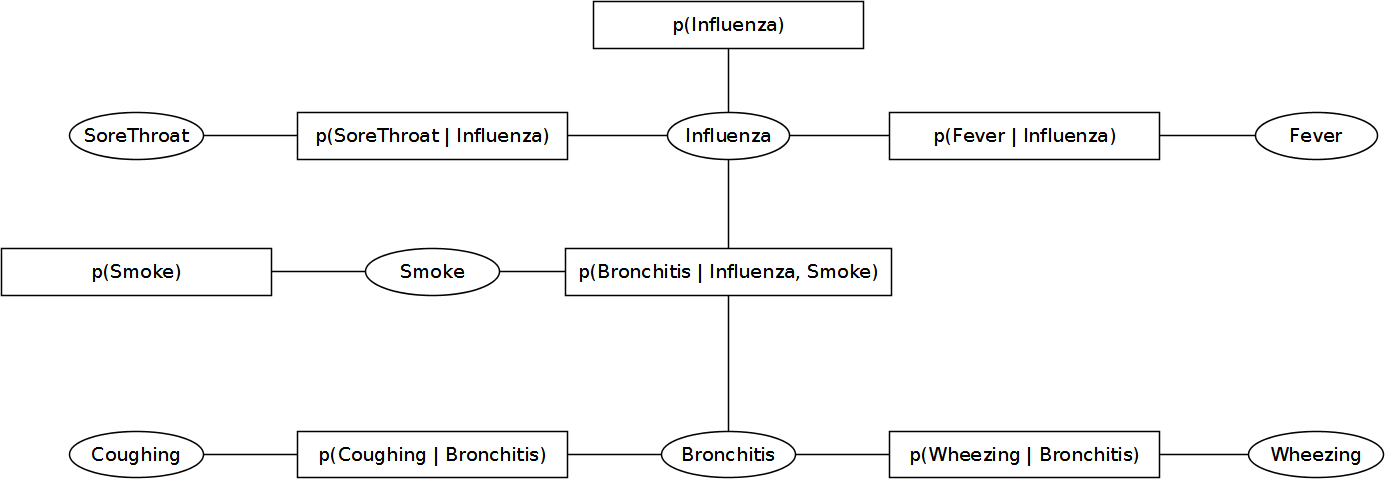

In [42]:
Influenza = Variable(name='Influenza', num_states=2)
Influenza_prior = Factor(name='p(Influenza)',
                 f=np.array([0.95, 0.05]),
                 neighbours=[Influenza])

Smoke = Variable(name='Smoke', num_states=2)
Smoke_prior = Factor(name='p(Smoke)',
                 f=np.array([0.80, 0.20]),
                 neighbours=[Smoke])
                 
Bronchitis = Variable(name='Bronchitis', num_states=2)
Bronchitis_cond = Factor(name='p(Bronchitis | Influenza, Smoke)',
                 f=np.array([
                 [[0.9999, 0.3], [0.1, 0.01]],
                 [[0.0001, 0.7], [0.9, 0.99]],
                 ]),
                 neighbours=[Bronchitis, Influenza, Smoke])  

SoreThroat = Variable(name='SoreThroat', num_states=2)
SoreThroat_cond = Factor(name='p(SoreThroat | Influenza)',
                 f=np.array([
                     [0.999, 0.70], [0.001, 0.30],
                 ]),
                 neighbours=[SoreThroat, Influenza]) 

Fever = Variable(name='Fever', num_states=2)
Fever_cond = Factor(name='p(Fever | Influenza)',
                 f=np.array([
                     [0.95, 0.10], [0.05, 0.90],
                 ]),
                 neighbours=[Fever, Influenza]) 

Coughing = Variable(name='Coughing', num_states=2)
Coughing_cond = Factor(name='p(Coughing | Bronchitis)',
                 f=np.array([
                     [0.93, 0.20], [0.07, 0.80],
                 ]),
                 neighbours=[Coughing, Bronchitis]) 

Wheezing = Variable(name='Wheezing', num_states=2)
Wheezing_cond = Factor(name='p(Wheezing | Bronchitis)',
                 f=np.array([
                     [0.999, 0.40], [0.001, 0.60],
                 ]),
                 neighbours=[Wheezing, Bronchitis]) 

### 3.2. Sum-product algorithm (10 points)

3.2.1 Run the sum-product algorithm on an unobserved graph. Print the marginal for every variable node.

In [43]:
# maybe I just ordered it in a bad way..?
nodes = [Influenza_prior, SoreThroat, Smoke_prior, Coughing,
         Wheezing, Fever, SoreThroat_cond, Fever_cond, Coughing_cond, Wheezing_cond, 
         Smoke, Bronchitis, Influenza, Bronchitis_cond]

leaves = [Influenza_prior, SoreThroat, Fever, Smoke_prior, Coughing, Wheezing]

for n in nodes:
    n.reset()

for l in leaves:
    for n in l.neighbours:
        l.pending.add(n)

sum_product(nodes)

print('\n')
for n in nodes:
    if type(n) == Variable:
        print(f'Marginal of {n} is {n.marginal()}')

Forward pass
p(Influenza) -> Influenza: [0.95 0.05]
SoreThroat -> p(SoreThroat | Influenza): [1. 1.]
p(Smoke) -> Smoke: [0.8 0.2]
Coughing -> p(Coughing | Bronchitis): [1. 1.]
Wheezing -> p(Wheezing | Bronchitis): [1. 1.]
Fever -> p(Fever | Influenza): [1. 1.]
p(SoreThroat | Influenza) -> Influenza: [1. 1.]
p(Fever | Influenza) -> Influenza: [1. 1.]
p(Coughing | Bronchitis) -> Bronchitis: [1. 1.]
p(Wheezing | Bronchitis) -> Bronchitis: [1. 1.]
Smoke -> p(Bronchitis | Influenza, Smoke): [0.8 0.2]
Bronchitis -> p(Bronchitis | Influenza, Smoke): [1. 1.]
Influenza -> p(Bronchitis | Influenza, Smoke): [0.95 0.05]

Backward pass
p(Bronchitis | Influenza, Smoke) -> Influenza: [1. 1.]
p(Bronchitis | Influenza, Smoke) -> Bronchitis: [0.821024 0.178976]
p(Bronchitis | Influenza, Smoke) -> Smoke: [1. 1.]
Influenza -> p(SoreThroat | Influenza): [0.95 0.05]
Influenza -> p(Influenza): [1. 1.]
Influenza -> p(Fever | Influenza): [0.95 0.05]
Bronchitis -> p(Wheezing | Bronchitis): [0.821024 0.178976]
B

3.2.2 Rerun the sum-product algorithm on an partially observed graph, where the variable 'Influenza' is set to 0. Print the marginal for every variable node.

In [44]:
for n in nodes:
    n.reset()

for l in leaves:
    for n in l.neighbours:
        l.pending.add(n)

Influenza.set_observed(0)

sum_product(nodes)

print('\n')
for n in nodes:
    if type(n) == Variable:
        print(f'Marginal of {n} is {n.marginal()}')

Forward pass
p(Influenza) -> Influenza: [0.95 0.05]
SoreThroat -> p(SoreThroat | Influenza): [1. 1.]
p(Smoke) -> Smoke: [0.8 0.2]
Coughing -> p(Coughing | Bronchitis): [1. 1.]
Wheezing -> p(Wheezing | Bronchitis): [1. 1.]
Fever -> p(Fever | Influenza): [1. 1.]
p(SoreThroat | Influenza) -> Influenza: [1. 1.]
p(Fever | Influenza) -> Influenza: [1. 1.]
p(Coughing | Bronchitis) -> Bronchitis: [1. 1.]
p(Wheezing | Bronchitis) -> Bronchitis: [1. 1.]
Smoke -> p(Bronchitis | Influenza, Smoke): [0.8 0.2]
Bronchitis -> p(Bronchitis | Influenza, Smoke): [1. 1.]
Influenza -> p(Bronchitis | Influenza, Smoke): [9.5e-01 5.0e-12]

Backward pass
p(Bronchitis | Influenza, Smoke) -> Influenza: [1. 1.]
p(Bronchitis | Influenza, Smoke) -> Bronchitis: [0.816924 0.133076]
p(Bronchitis | Influenza, Smoke) -> Smoke: [0.95 0.95]
Influenza -> p(SoreThroat | Influenza): [9.5e-01 5.0e-12]
Influenza -> p(Influenza): [1.e+00 1.e-10]
Influenza -> p(Fever | Influenza): [9.5e-01 5.0e-12]
Bronchitis -> p(Wheezing | Bron

### 3.3. max-sum algorithm (10 points)

3.3.1 Run the max_sum algorithm on an unobserved graph. Print the marginal for every variable node.

In [45]:
for n in nodes:
    n.reset()

for l in leaves:
    for n in l.neighbours:
        l.pending.add(n)

max_sum(nodes)

print('\n')
for n in nodes:
    if type(n) == Variable:
        print(f'Unnormalized log-marginal of {n} is {n.unnormalized_log_marginal()}')

Forward pass
p(Influenza) -> Influenza: [0.95 0.05]
SoreThroat -> p(SoreThroat | Influenza): [1. 1.]
p(Smoke) -> Smoke: [0.8 0.2]
Coughing -> p(Coughing | Bronchitis): [1. 1.]
Wheezing -> p(Wheezing | Bronchitis): [1. 1.]
Fever -> p(Fever | Influenza): [1. 1.]
p(SoreThroat | Influenza) -> Influenza: [0.999 0.7  ]
p(Fever | Influenza) -> Influenza: [0.95 0.9 ]
p(Coughing | Bronchitis) -> Bronchitis: [0.93 0.8 ]
p(Wheezing | Bronchitis) -> Bronchitis: [0.999 0.6  ]
Smoke -> p(Bronchitis | Influenza, Smoke): [0.8 0.2]
Bronchitis -> p(Bronchitis | Influenza, Smoke): [0.92907 0.48   ]
Influenza -> p(Bronchitis | Influenza, Smoke): [0.9015975 0.0315   ]

Backward pass
p(Bronchitis | Influenza, Smoke) -> Influenza: [0.74318167 0.3456    ]
p(Bronchitis | Influenza, Smoke) -> Bronchitis: [0.72120587 0.12622365]
p(Bronchitis | Influenza, Smoke) -> Smoke: [0.83756342 0.30293676]
Influenza -> p(SoreThroat | Influenza): [0.67072146 0.015552  ]
Influenza -> p(Influenza): [0.70531657 0.217728  ]
Infl

3.3.2 Rerun the max_sum algorithm on an partially observed graph, where the variable 'Influenza' is set to 0. Print the marginal for every variable node.

In [46]:
for n in nodes:
    n.reset()

for l in leaves:
    for n in l.neighbours:
        l.pending.add(n)

Influenza.set_observed(0)

max_sum(nodes)

print('\n')
for n in nodes:
    if type(n) == Variable:
        print(f'Unnormalized log-marginal of {n} is {n.unnormalized_log_marginal()}')

Forward pass
p(Influenza) -> Influenza: [9.5e-01 5.0e-12]
SoreThroat -> p(SoreThroat | Influenza): [1. 1.]
p(Smoke) -> Smoke: [0.8 0.2]
Coughing -> p(Coughing | Bronchitis): [1. 1.]
Wheezing -> p(Wheezing | Bronchitis): [1. 1.]
Fever -> p(Fever | Influenza): [1. 1.]
p(SoreThroat | Influenza) -> Influenza: [0.999 0.7  ]
p(Fever | Influenza) -> Influenza: [0.95 0.1 ]
p(Coughing | Bronchitis) -> Bronchitis: [0.93 0.8 ]
p(Wheezing | Bronchitis) -> Bronchitis: [0.999 0.6  ]
Smoke -> p(Bronchitis | Influenza, Smoke): [0.8 0.2]
Bronchitis -> p(Bronchitis | Influenza, Smoke): [0.92907 0.48   ]
Influenza -> p(Bronchitis | Influenza, Smoke): [9.015975e-01 3.500000e-23]

Backward pass
p(Bronchitis | Influenza, Smoke) -> Influenza: [0.74318167 0.3456    ]
p(Bronchitis | Influenza, Smoke) -> Bronchitis: [0.72120587 0.12622365]
p(Bronchitis | Influenza, Smoke) -> Smoke: [0.83756342 0.30293676]
Influenza -> p(SoreThroat | Influenza): [6.70721461e-01 1.72800000e-23]
Influenza -> p(Influenza): [7.05316